## Model Testing
* This notebook houses attempts to better the Base Models created in NoAugBaseModel.ipynb and AugBaseModel.ipynb
* Minor changes such as epochs, and standardization or normalization will be done to try to get better results
* Housing all this in one notebook is not best practice, but what works for me

In [1]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import keras
from tensorflow.keras import layers, models

/Users/Temp/Data4380/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#dataloader module
import Vision_Dataloader as vd

In [ ]:
#reimport if necessary (edit file after already imported)
import importlib
importlib.reload(vd)

In [3]:
def make_transfer_model(input_shape):
    backbone = keras.applications.EfficientNetB0(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = True
    for layer in backbone.layers[:-50]:
        layer.trainable = False

    inputs = layers.Input(input_shape)
    #x = keras.applications.efficientnet.preprocess_input(inputs) #incorporated in dataloader module
    x = backbone(inputs)
    x = layers.Dropout(0.3)(x)
    
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.25)(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)

    outputs = layers.Dense(2, activation='linear')(x)

    return keras.Model(inputs, outputs, name="Tell_Time")

#### Test 1
* NoAugBaseModel but with 50 epochs (instead of the original 25)
    * No augmentation
    * Standardization
    * image size = (224,224)
    * images = 1000
    * batches = 64
    * epochs = 50

In [10]:
train_ds,val_ds,targetstats=vd.image_loader('watch_faces_train.parquet',target='list',batches=64,augmentation=False,standardize=True,img_size=(224, 224))

In [5]:
epochs = 50

callbacks = [
    #keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model=make_transfer_model(input_shape=(224, 224, 3))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4),loss='mse',metrics=['mae'])

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 1.0963 - mae: 0.8889 - val_loss: 1.0553 - val_mae: 0.8862
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 976ms/step - loss: 0.9139 - mae: 0.8069 - val_loss: 1.0149 - val_mae: 0.8763
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 962ms/step - loss: 0.8344 - mae: 0.7788 - val_loss: 0.9805 - val_mae: 0.8611
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 962ms/step - loss: 0.7382 - mae: 0.7255 - val_loss: 0.9689 - val_mae: 0.8421
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 980ms/step - loss: 0.6916 - mae: 0.6912 - val_loss: 0.8962 - val_mae: 0.8019
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.5948 - mae: 0.6280 - val_loss: 0.8331 - val_mae: 0.7559
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 984ms/step - loss: 0.5236 - mae: 0.5848 - val_loss: 0.7668 - val_mae: 0.7207
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 972ms/step - loss: 0.4561 - mae: 0.5323 - val_loss: 0.7209 - val_mae: 0.6930
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 954ms/step -

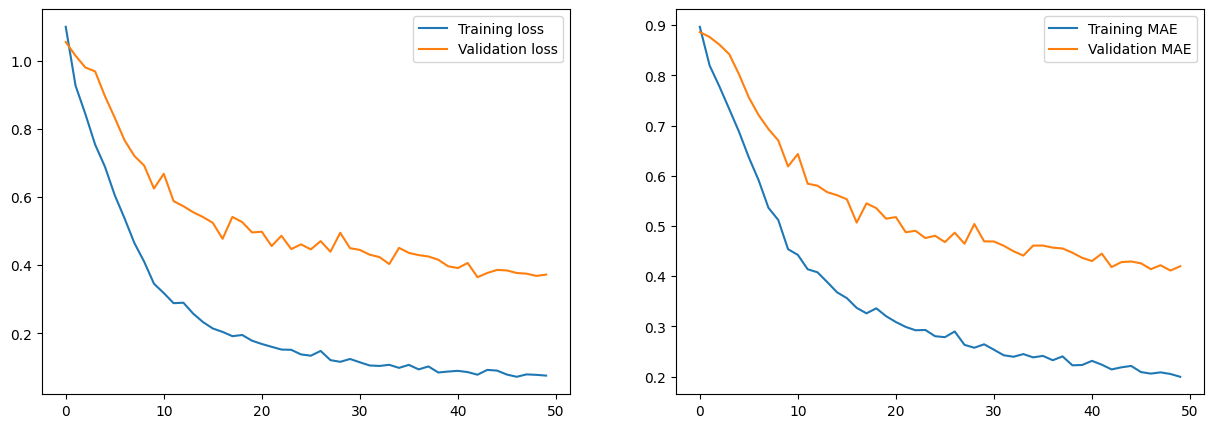

In [6]:
plt.figure(figsize=(15, 5))


plt.subplot(1, 2, 1)
#mean squared error
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation loss")
plt.legend()

plt.subplot(1, 2, 2)
#mean absolute error
plt.plot(range(len(history.history['mae'])),history.history['mae'],label="Training MAE")
plt.plot(range(len(history.history['val_mae'])),history.history['val_mae'],label="Validation MAE")
plt.legend()

2025-07-18 19:28:48.779944: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


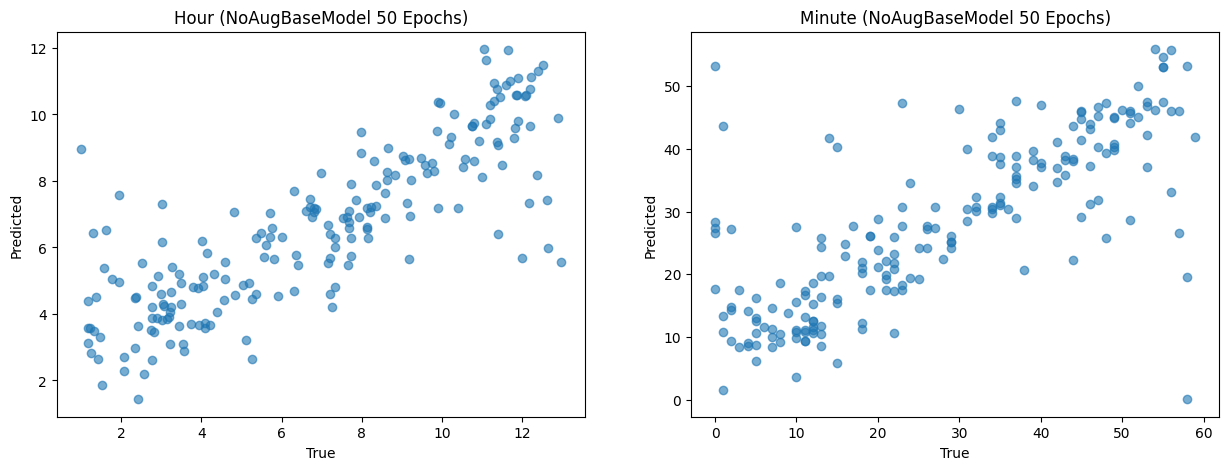

In [7]:
t1_true=[]
t1_pred=[]
for image, label in val_ds.unbatch():
    image=tf.expand_dims(image,axis=0)
    pred=model.predict(image,verbose=0)[0]
    t1_pred.append(pred)
    t1_true.append(label.numpy())

t1_true=np.array(t1_true)
t1_pred=np.array(t1_pred)

plt.figure(figsize=(15, 5))

#hour
plt.subplot(1, 2, 1)
plt.scatter(t1_true[:,0]*targetstats['Hour']['std']+targetstats['Hour']['mean'], t1_pred[:,0]*targetstats['Hour']['std']+targetstats['Hour']['mean'], alpha=0.6)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Hour (NoAugBaseModel 50 Epochs)')

#minute
plt.subplot(1, 2, 2)
plt.scatter(t1_true[:,1]*targetstats['Minute']['std']+targetstats['Minute']['mean'], t1_pred[:,1]*targetstats['Minute']['std']+targetstats['Minute']['mean'], alpha=0.6)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Minute (NoAugBaseModel 50 Epochs)')

plt.show()

#### Test 2
* NoAugBaseModel with 50 epochs and Normalization
    * No augmentation
    * Normalization
    * image size = (224,224)
    * images = 1000
    * batches = 64
    * epochs = 50

In [11]:
train_ds2,val_ds2=vd.image_loader('watch_faces_train.parquet',target='list',batches=64,augmentation=False,standardize=False,img_size=(224, 224)) #2 added to differentiate from Test 1

In [12]:
epochs = 50

callbacks = [
    #keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model2=make_transfer_model(input_shape=(224, 224, 3))

model2.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4),loss='mse',metrics=['mae'])

history2 = model2.fit( #2 added to differentiate from Test 1
    train_ds2,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds2,
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.5347 - mae: 0.5807 - val_loss: 0.2559 - val_mae: 0.4141
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 956ms/step - loss: 0.1471 - mae: 0.3084 - val_loss: 0.1450 - val_mae: 0.3111
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 946ms/step - loss: 0.1029 - mae: 0.2572 - val_loss: 0.1107 - val_mae: 0.2734
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 973ms/step - loss: 0.0896 - mae: 0.2445 - val_loss: 0.1026 - val_mae: 0.2621
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 951ms/step - loss: 0.0866 - mae: 0.2399 - val_loss: 0.0921 - val_mae: 0.2511
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 952ms/step - loss: 0.0758 - mae: 0.2223 - val_loss: 0.0903 - val_mae: 0.2483
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 942ms/step - loss: 0.0717 - mae: 0.2165 - val_loss: 0.0864 - val_mae: 0.2453
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 969ms/step - loss: 0.0666 - mae: 0.2111 - val_loss: 0.0856 - val_mae: 0.2405
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 971ms/ste

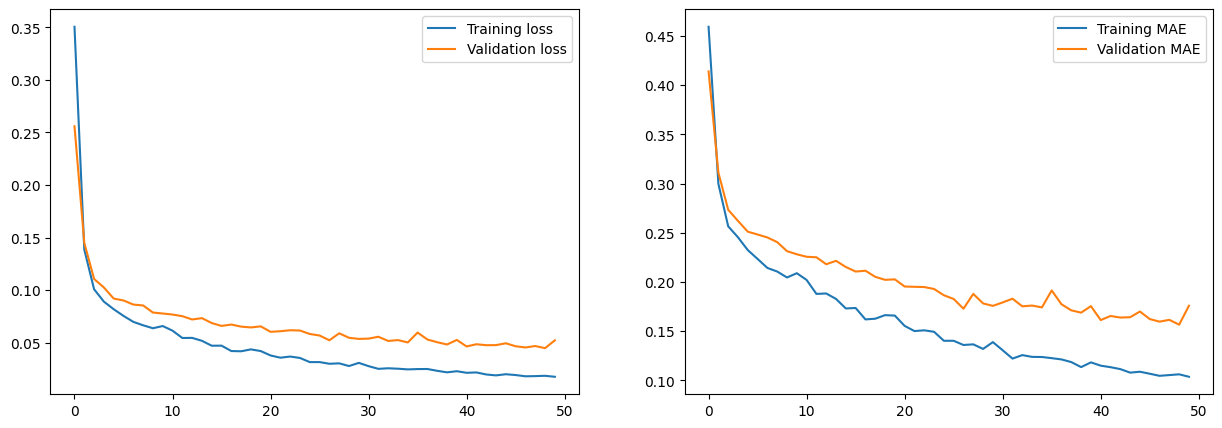

In [13]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
#mean squared error
plt.plot(range(len(history2.history["loss"])),history2.history["loss"],label="Training loss")
plt.plot(range(len(history2.history["val_loss"])),history2.history["val_loss"],label="Validation loss")
plt.legend()

plt.subplot(1, 2, 2)
#mean absolute error
plt.plot(range(len(history2.history['mae'])),history2.history['mae'],label="Training MAE")
plt.plot(range(len(history2.history['val_mae'])),history2.history['val_mae'],label="Validation MAE")
plt.legend()

2025-07-18 19:53:22.735148: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


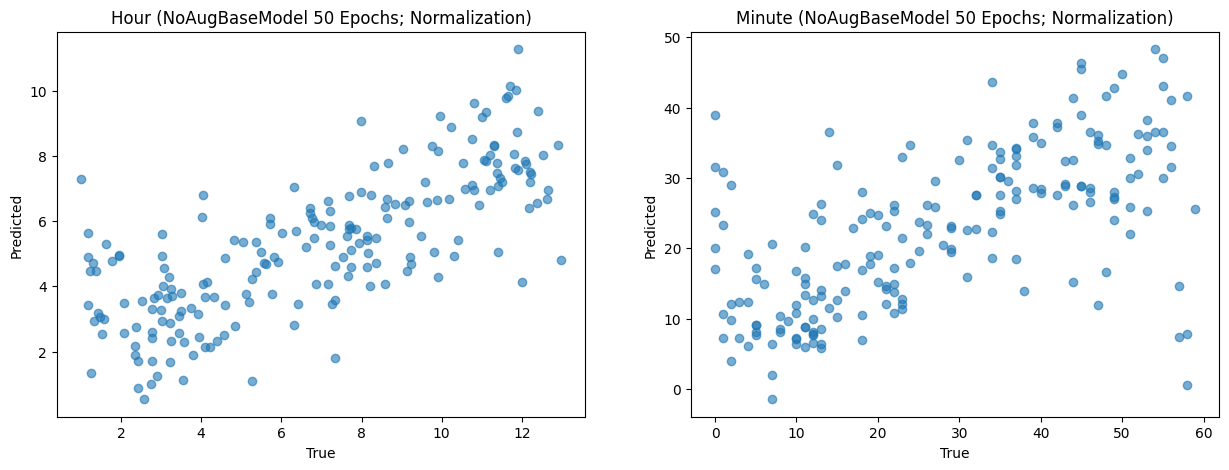

In [16]:
t2_true=[]
t2_pred=[]
for image, label in val_ds2.unbatch():
    image=tf.expand_dims(image,axis=0)
    pred=model2.predict(image,verbose=0)[0]
    t2_pred.append(pred)
    t2_true.append(label.numpy())

t2_true=np.array(t2_true)
t2_pred=np.array(t2_pred)

plt.figure(figsize=(15, 5))

#hour
plt.subplot(1, 2, 1)
plt.scatter(t2_true[:,0]*13, t2_pred[:,0]*13, alpha=0.6)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Hour (NoAugBaseModel 50 Epochs; Normalization)')

#minute
plt.subplot(1, 2, 2)
plt.scatter(t2_true[:,1]*60, t2_pred[:,1]*60, alpha=0.6)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Minute (NoAugBaseModel 50 Epochs; Normalization)')

plt.show()

* MAE is technically lower than for Test 1; however, that is looking at the numbers without context
    * Test 2 uses Normalization, making the range of values 0-1; thus, the MAE would also be small
* Test 1 is the better model of the two, as seen in the scatter plots for True vs Predicted

#### Test 3: Revert to Test 1 but increase Epochs to 100
* No augmentation
* Standardization
* image size = (224,224)
* images = 1000
* batches = 64
* epochs = 100

In [26]:
#using same dataset called in Test 1; change epochs value to 100

epochs = 100

callbacks = [
    #keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model3=make_transfer_model(input_shape=(224, 224, 3))

model3.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4),loss='mse',metrics=['mae'])

history3 = model3.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 1.1508 - mae: 0.9142 - val_loss: 1.0983 - val_mae: 0.9034
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 991ms/step - loss: 0.9750 - mae: 0.8461 - val_loss: 1.0268 - val_mae: 0.8798
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 927ms/step - loss: 0.8483 - mae: 0.7825 - val_loss: 1.0055 - val_mae: 0.8690
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 997ms/step - loss: 0.7822 - mae: 0.7394 - val_loss: 0.9858 - val_mae: 0.8544
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 960ms/step - loss: 0.7043 - mae: 0.6998 - val_loss: 0.9881 - val_mae: 0.8395
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 895ms/step - loss: 0.6133 - mae: 0.6350 - val_loss: 0.9108 - val_mae: 0.7965
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.5613 - mae: 0.6034 - val_loss: 0.9163 - val_mae: 0.7901
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.5248 - mae: 0.5813 - val_loss: 0.8181 - val_mae: 0.7500
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/ste

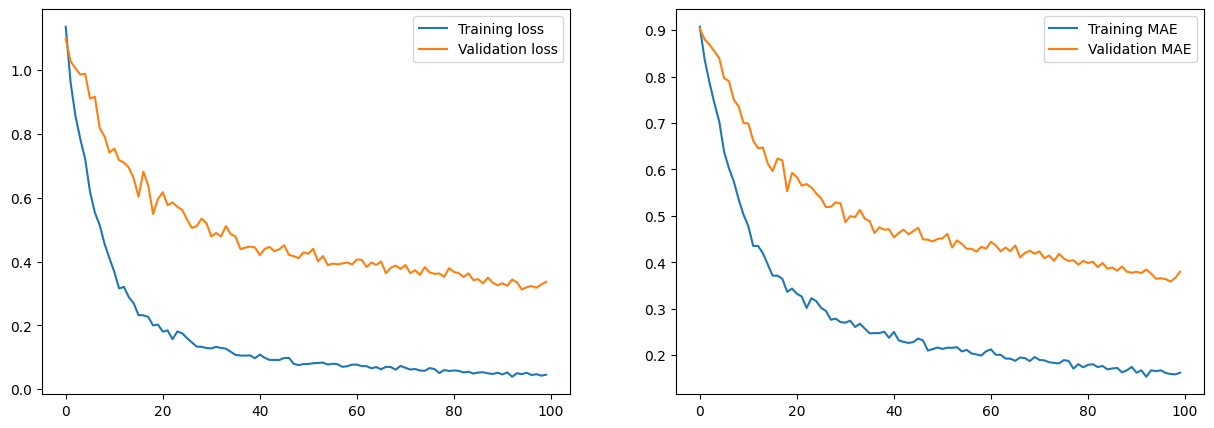

In [27]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
#mean squared error
plt.plot(range(len(history3.history["loss"])),history3.history["loss"],label="Training loss")
plt.plot(range(len(history3.history["val_loss"])),history3.history["val_loss"],label="Validation loss")
plt.legend()

plt.subplot(1, 2, 2)
#mean absolute error
plt.plot(range(len(history3.history['mae'])),history3.history['mae'],label="Training MAE")
plt.plot(range(len(history3.history['val_mae'])),history3.history['val_mae'],label="Validation MAE")
plt.legend()

2025-07-18 22:48:43.751520: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


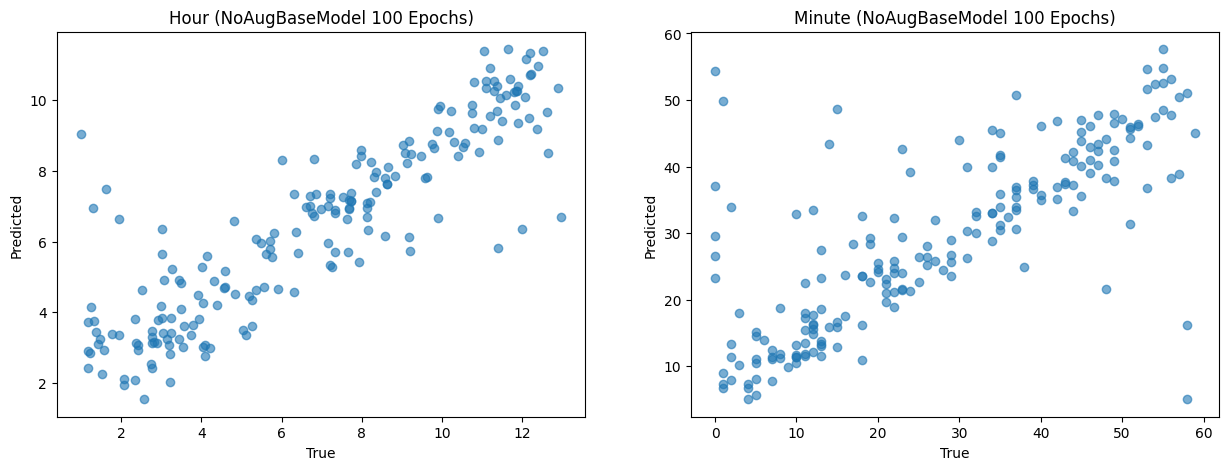

In [28]:
t3_true=[]
t3_pred=[]
for image, label in val_ds.unbatch():
    image=tf.expand_dims(image,axis=0)
    pred=model3.predict(image,verbose=0)[0]
    t3_pred.append(pred)
    t3_true.append(label.numpy())

t3_true=np.array(t3_true)
t3_pred=np.array(t3_pred)

plt.figure(figsize=(15, 5))

#hour
plt.subplot(1, 2, 1)
plt.scatter(t3_true[:,0]*targetstats['Hour']['std']+targetstats['Hour']['mean'], t3_pred[:,0]*targetstats['Hour']['std']+targetstats['Hour']['mean'], alpha=0.6)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Hour (NoAugBaseModel 100 Epochs)')

#minute
plt.subplot(1, 2, 2)
plt.scatter(t3_true[:,1]*targetstats['Minute']['std']+targetstats['Minute']['mean'], t3_pred[:,1]*targetstats['Minute']['std']+targetstats['Minute']['mean'], alpha=0.6)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Minute (NoAugBaseModel 100 Epochs)')

plt.show()

* MAE = 0.3799
* scatter plot visually also looks shows the better performance

#### Test 4: Test 3 but with Augmentation
* Augmentation
* Standardization
* image size = (224,224)
* images = 1000
* batches = 64
* epochs = 100

In [20]:
train_ds4,val_ds4,targetstats4=vd.image_loader('watch_faces_train.parquet',target='list',batches=64,augmentation=True,standardize=True,img_size=(224, 224))

In [21]:
epochs = 100

callbacks = [
    #keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model4=make_transfer_model(input_shape=(224, 224, 3))

model4.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4),loss='mse',metrics=['mae'])

history4 = model4.fit(
    train_ds4,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds4,
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 1.1743 - mae: 0.9108 - val_loss: 1.0318 - val_mae: 0.8727
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 1.0317 - mae: 0.8745 - val_loss: 1.0305 - val_mae: 0.8785
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.9282 - mae: 0.8269 - val_loss: 1.0764 - val_mae: 0.8911
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 0.9798 - mae: 0.8497 - val_loss: 1.0857 - val_mae: 0.8914
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.9091 - mae: 0.8143 - val_loss: 1.0883 - val_mae: 0.8881
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 919ms/step - loss: 0.9039 - mae: 0.8059 - val_loss: 1.1212 - val_mae: 0.8930
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 914ms/step - loss: 0.8250 - mae: 0.7692 - val_loss: 1.0993 - val_mae: 0.8734
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 914ms/step - loss: 0.7908 - mae: 0.7375 - val_loss: 1.1428 - val_mae: 0.8747
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 911ms/step -

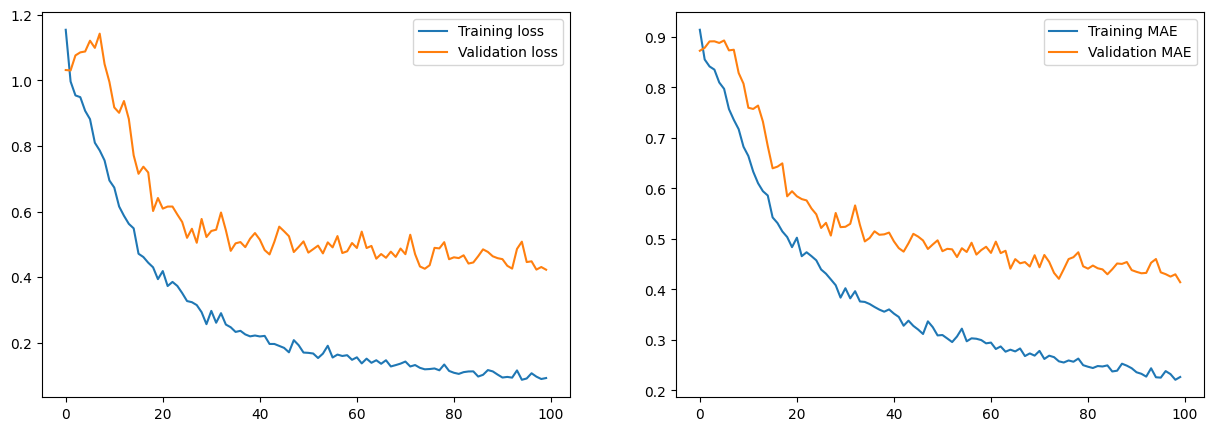

In [22]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
#mean squared error
plt.plot(range(len(history4.history["loss"])),history4.history["loss"],label="Training loss")
plt.plot(range(len(history4.history["val_loss"])),history4.history["val_loss"],label="Validation loss")
plt.legend()

plt.subplot(1, 2, 2)
#mean absolute error
plt.plot(range(len(history4.history['mae'])),history4.history['mae'],label="Training MAE")
plt.plot(range(len(history4.history['val_mae'])),history4.history['val_mae'],label="Validation MAE")
plt.legend()

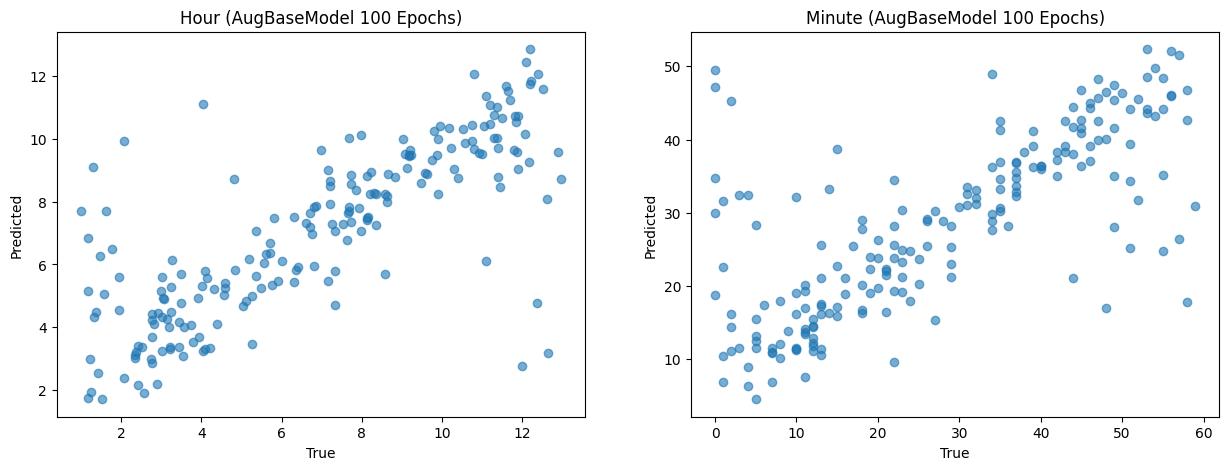

In [24]:
t4_true=[]
t4_pred=[]
for image, label in val_ds4.unbatch():
    image=tf.expand_dims(image,axis=0)
    pred=model4.predict(image,verbose=0)[0]
    t4_pred.append(pred)
    t4_true.append(label.numpy())

t4_true=np.array(t4_true)
t4_pred=np.array(t4_pred)

plt.figure(figsize=(15, 5))

#hour
plt.subplot(1, 2, 1)
plt.scatter(t4_true[:,0]*targetstats4['Hour']['std']+targetstats4['Hour']['mean'], t4_pred[:,0]*targetstats4['Hour']['std']+targetstats4['Hour']['mean'], alpha=0.6)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Hour (AugBaseModel 100 Epochs)')

#minute
plt.subplot(1, 2, 2)
plt.scatter(t4_true[:,1]*targetstats4['Minute']['std']+targetstats4['Minute']['mean'], t4_pred[:,1]*targetstats4['Minute']['std']+targetstats4['Minute']['mean'], alpha=0.6)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Minute (AugBaseModel 100 Epochs)')

plt.show()

* MAE = 0.4143; better than AugBaseModel but still worse than Test 3 (NoAug w/ 100 Epochs)

In [29]:
#save test 3 because it was the best
model3.save('NoAug100Epochs.keras')

#### Model Notes
* Best model = Test 3 (NoAugBaseModel using 100 epochs)
    * MAE = 0.3799; average error was less than half a standard deviation
* Only very minor changes were done in testing models (number of epochs, standardization vs. normalization, augmentation vs. no augmentation)
* If return to in future, should try to the following to improve model or further explore:
    * decrease sample size to see how little can be used to create a usable model
    * try transfer learning with other backbones (EfficientNetB1-7, ResNet, etc.)
    * testing different batch sizes
    * testing different learning rates
    * using early stopping to revert back to best weights when training model

In [2]:
import pandas as pd
metrics=pd.DataFrame({'Model':['Scaling','Augmentation','MSE','MAE'],
                      'NoAugBase':['Standardization','No',0.4490,0.4909],
                      'AugBase':['Standardization','Yes',0.5439,0.5366],
                      'Test1':['Standardization','No',0.3726,0.4197],
                      'Test2':['Normalization','No',0.0524,0.1759],
                      'Test3':['Standardization','No',0.3363,0.3799],
                      'Test4':['Standardization','Yes',0.4232,0.4143]
                      })
metrics

,Model,NoAugBase,AugBase,Test1,Test2,Test3,Test4
0,Scaling,Standardization,Standardization,Standardization,Normalization,Standardization,Standardization
1,Augmentation,No,Yes,No,No,No,Yes
2,MSE,0.449,0.5439,0.3726,0.0524,0.3363,0.4232
3,MAE,0.4909,0.5366,0.4197,0.1759,0.3799,0.4143
